# ЧАСТЬ №1. ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ ФОНДОВОГО РЫНКА.

 <b>рынок:</b> Бразилия<br>
 <b>период:</b> 2018 год

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv("..\data_log_return.csv")
tickers = list(data.columns)
tickers.pop(0)

'Date'

# 1. Оценка ожидаемых доходностей и стандартных отклонений.

Для того, чтобы оценить ожидаемые доходности и стандартные отклонения мы используем функции mean() и std(). В нашей табличке уже есть логарифмические доходности по дням для каждой акции. Именно их мы и будем использовать для подсчетов.

In [135]:
# Вычисление оценки ожидаемых доходностей и стандартных отклонений
def find_E_n_sigma(data, tickers):
    expected_returns = {}
    risks = {}

    to_delete = []

    for ticker in tickers:
        risk = data[ticker].std()
        expected_returns[ticker] = data[ticker].mean()
        risks[ticker] = risk

    risk_and_return = pd.DataFrame({
        'Ticker': expected_returns.keys(),
        'E': expected_returns.values(),
        'σ': risks.values()
    })
    return risk_and_return

risk_and_return = find_E_n_sigma(data, tickers)

Построим «карту» активов в системе координат (σ, E).

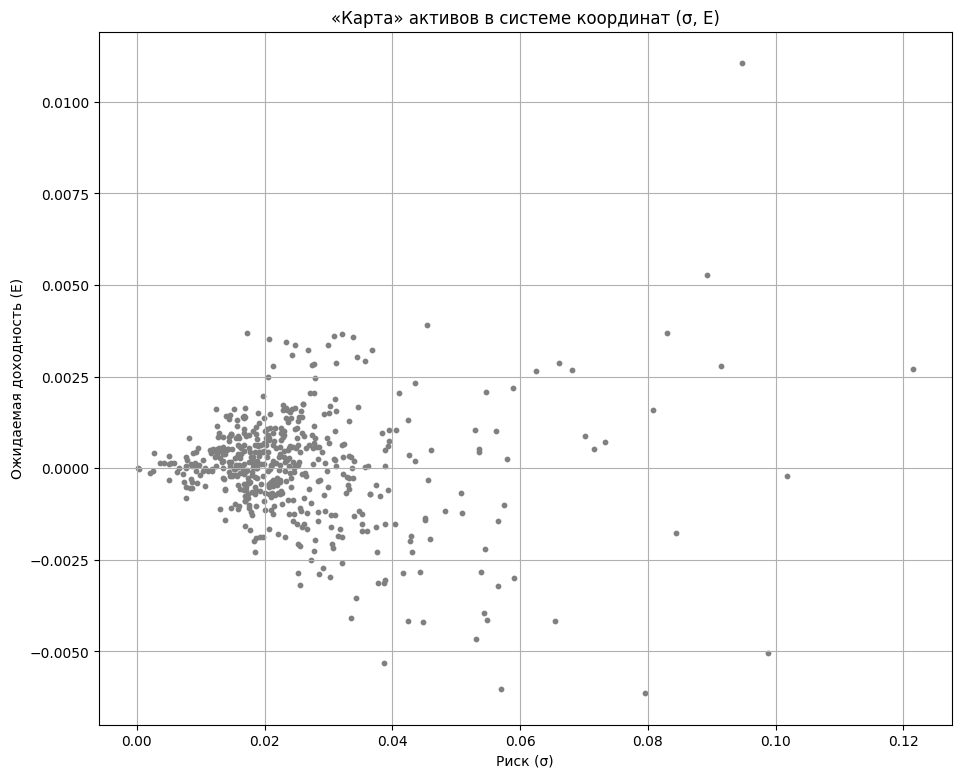

In [136]:
# Построение карты активов с выделенными выбранными.
plt.figure(figsize=(11, 9))
plt.scatter(risk_and_return['σ'], risk_and_return['E'], s=10, color='grey')
plt.title('«Карта» активов в системе координат (σ, E)')
plt.xlabel('Риск (σ)')
plt.ylabel('Ожидаемая доходность (E)')
plt.grid()
plt.show()

# 2. Парето-оптимальные активы.

Парето-оптимальные активы - активы, характеристики которых нельзя улучшить сразу по двум критериям. Это значит, что нет активов у которых одновременно больше доходность и меньше риск.

In [137]:
# Функция для поиска Парето-оптимальных активов
pareto_optimal_assets = []

for i in range(len(risk_and_return['Ticker'])):
    current_E = risk_and_return['E'][i]
    current_Sigma = risk_and_return['σ'][i]
    is_optimal = True
    for j in range(len(risk_and_return['Ticker'])):
        if i != j:
            if (risk_and_return['E'][j] >= current_E and risk_and_return['σ'][j] <= current_Sigma):
                is_optimal = False
                break
    if is_optimal:
        pareto_optimal_assets.append(risk_and_return['Ticker'][i])

pareto_optimal = find_E_n_sigma(data, pareto_optimal_assets)
print(pareto_optimal.sort_values('E'))

      Ticker         E         σ
4   HETA3.SA  0.000010  0.000160
9  NPAR11.SA  0.000408  0.002748
1   CEGR3.SA  0.000819  0.008155
2   CPFE3.SA  0.001613  0.012433
8  MRCK34.SA  0.001626  0.015278
6  LILY34.SA  0.001648  0.016880
5   IRBR3.SA  0.003700  0.017212
7   LOGN3.SA  0.003912  0.045399
0   AZEV3.SA  0.005261  0.089274
3   EQPA6.SA  0.011053  0.094818


Всего у нас получилось 10 Парето-оптимальных активов. Теперь покажем их на общей карте.

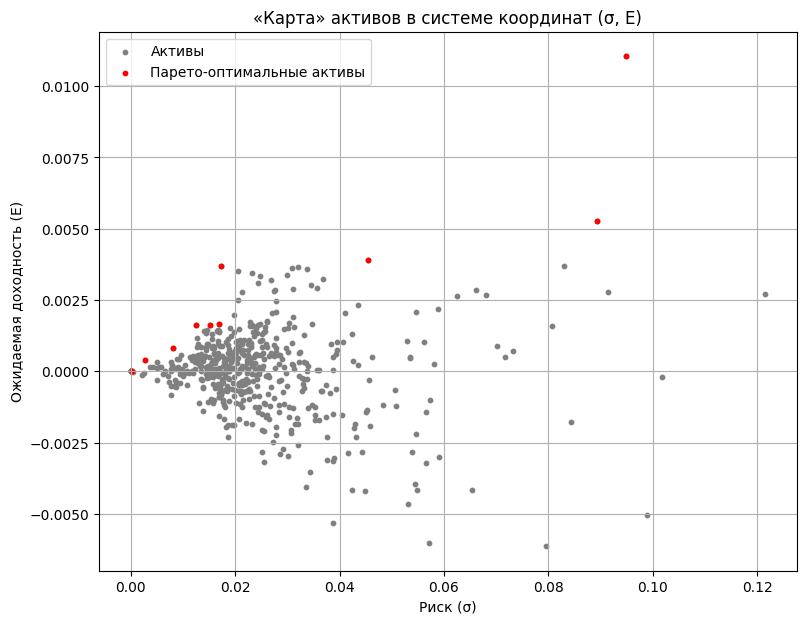

In [110]:
# Построение карты активов в системе координат (σ, E)
plt.figure(figsize=(9, 7))
plt.scatter(risk_and_return['σ'], risk_and_return['E'], s=10, color='grey', label='Активы')
plt.scatter(pareto_optimal['σ'], pareto_optimal['E'], s=10, color='red', label='Парето-оптимальные активы')
plt.title('«Карта» активов в системе координат (σ, E)')
plt.xlabel('Риск (σ)')
plt.ylabel('Ожидаемая доходность (E)')
plt.legend()
plt.grid()
plt.show()

# 3. Value at Risk и Conditional Value at Risk
### - Оценка VaR / CVaR с уровнем доверия 0,95 для Парето-оптимальных активов рынка.
### - Какие из активов наиболее предпочтительны по этим характеристикам?
### - Где они расположены на карте активов?
### - Сравнить результаты VaR и CVaR

Для того, чтобы оценить VaR и CVaR для Парето-оптивальных активов, воспользуемся 3 методами: историческим, параметрическим и Монте-Карло. Уровень доверия зададим равным 95.

In [130]:
from scipy.stats import norm

confidence_level = 95

def monte_carlo_simulation(returns, num_simulations=10000):
    mean = returns.mean()
    std_dev = returns.std()
    simulated_returns = np.random.normal(mean, std_dev, (num_simulations, len(returns)))
    return simulated_returns

def calculate_historical_var_cvar(returns, confidence_level):
    var = -np.percentile(returns, 100 - confidence_level)
    losses = -returns
    var_threshold = np.percentile(losses, confidence_level)
    cvar = losses[losses >= var_threshold].mean()
    return var, cvar

def calculate_parametric_var_cvar(returns, confidence_level):
    mean = returns.mean()
    std_dev = returns.std()
    var = -norm.ppf(1 - confidence_level / 100) * std_dev + mean
    cvar = -mean + std_dev * norm.pdf(norm.ppf(confidence_level / 100)) / (1 - confidence_level / 100)
    return var, cvar

def calculate_monte_carlo_var_cvar(simulated_returns, confidence_level):
    var = -np.percentile(simulated_returns, 100 - confidence_level, axis=0)
    losses = -simulated_returns
    var_threshold = np.percentile(losses, confidence_level, axis=0)
    cvar = losses[losses >= var_threshold].mean(axis=0)
    return var, cvar

Теперь перейдем к самой оценке. Мы будем сравнивать VaR и CVaR по методам, поэтому для каждого метода создадим отдельную табличку DataFrame.

In [131]:
historical_method = pd.DataFrame()
historical_method['Ticker'] = pareto_optimal_assets
historical_method = historical_method.set_index('Ticker')
historical_method['VaR'] = np.nan
historical_method['CVaR'] = np.nan

parametric_method = pd.DataFrame()
parametric_method['Ticker'] = pareto_optimal_assets
parametric_method = parametric_method.set_index('Ticker')
parametric_method['VaR'] = np.nan
parametric_method['CVaR'] = np.nan

monte_carlo_method = pd.DataFrame()
monte_carlo_method['Ticker'] = pareto_optimal_assets
monte_carlo_method = monte_carlo_method.set_index('Ticker')
monte_carlo_method['VaR'] = np.nan
monte_carlo_method['CVaR'] = np.nan

for ticker in pareto_optimal_assets:
    log_returns = data[ticker].dropna()

    var, cvar = calculate_historical_var_cvar(log_returns, confidence_level)
    if var == 0:
        historical_method.loc[ticker, 'VaR'] = 0
    else:
        historical_method.loc[ticker, 'VaR'] = var
    historical_method.loc[ticker, 'CVaR'] = cvar

    var, cvar = calculate_parametric_var_cvar(log_returns, confidence_level)
    parametric_method.loc[ticker, 'VaR'] = var
    parametric_method.loc[ticker, 'CVaR'] = cvar

    simulated_returns = monte_carlo_simulation(log_returns)
    var, cvar = calculate_monte_carlo_var_cvar(simulated_returns, confidence_level)
    if isinstance(var, np.ndarray):
        var = var.mean()
    if isinstance(cvar, np.ndarray):
        cvar = cvar.mean()
    monte_carlo_method.loc[ticker, 'VaR'] = var
    monte_carlo_method.loc[ticker, 'CVaR'] = cvar

print('==== Исторический метод =====')
print(historical_method.sort_values('VaR').sort_values('CVaR'))

print('\n=== Параметрический метод ===')
print(parametric_method.sort_values('VaR').sort_values('CVaR'))

print('\n===== Метод Монте-Карло =====')
print(monte_carlo_method.sort_values('VaR').sort_values('CVaR'))



==== Исторический метод =====
                VaR      CVaR
Ticker                       
HETA3.SA   0.000000  0.000000
CEGR3.SA   0.000000  0.000087
NPAR11.SA  0.000000  0.000116
EQPA6.SA   0.000000  0.003088
AZEV3.SA   0.000000  0.004870
CPFE3.SA   0.015884  0.019786
MRCK34.SA  0.022054  0.031770
IRBR3.SA   0.023965  0.032833
LILY34.SA  0.025329  0.038559
LOGN3.SA   0.058021  0.073103

=== Параметрический метод ===
                VaR      CVaR
Ticker                       
HETA3.SA   0.000273  0.000319
NPAR11.SA  0.004927  0.005259
CEGR3.SA   0.014233  0.016003
CPFE3.SA   0.022065  0.024033
MRCK34.SA  0.026756  0.029889
IRBR3.SA   0.032011  0.031803
LILY34.SA  0.029413  0.033170
LOGN3.SA   0.078586  0.089733
AZEV3.SA   0.152104  0.178886
EQPA6.SA   0.167014  0.184528

===== Метод Монте-Карло =====
                VaR      CVaR
Ticker                       
HETA3.SA   0.000252  0.000319
NPAR11.SA  0.004105  0.005252
CEGR3.SA   0.012588  0.016005
CPFE3.SA   0.018821  0.024014
MRCK34.S

VaR (Value at Risk) - это статистическая мера риска, которая определяет максимальный потенциальный убыт, который может быть получен из инвестиционного портфеля в течение определенного периода времени с определенной вероятностью. VaR положительный, когда он указывает на риск, и отрицательный, когда он указывает на возможный доход. Актив с меньшим VaR представляет менее рискованный вариант инвестирования, поскольку он предоставляет меньший потенциальный убыт.

CVaR (Conditional Value at Risk) - это расширение VaR, которое учитывает не только потенциальный убыт, но и уровень потерь, которые выше VaR. CVaR показывает средний убыт, который может быть получен из инвестиционного портфеля при условии, что потери превышают VaR.

Как мы видим нет ни одного актива с VaR и СVaR меньше нуля.

По полученным таблицам видно, что лучшим активом является 'HETA3.SA'. При подсчете любым методом у этого актива наименьшие VaR и CVaR. В историческом методе VaR и CVaR получились одинаковые и равны нулю. В двух других методах они не равны нулю и немного отличаются друг от друга.

Покажем найденный актив на карте.

       Ticker        E        σ
256  HETA3.SA  0.00001  0.00016


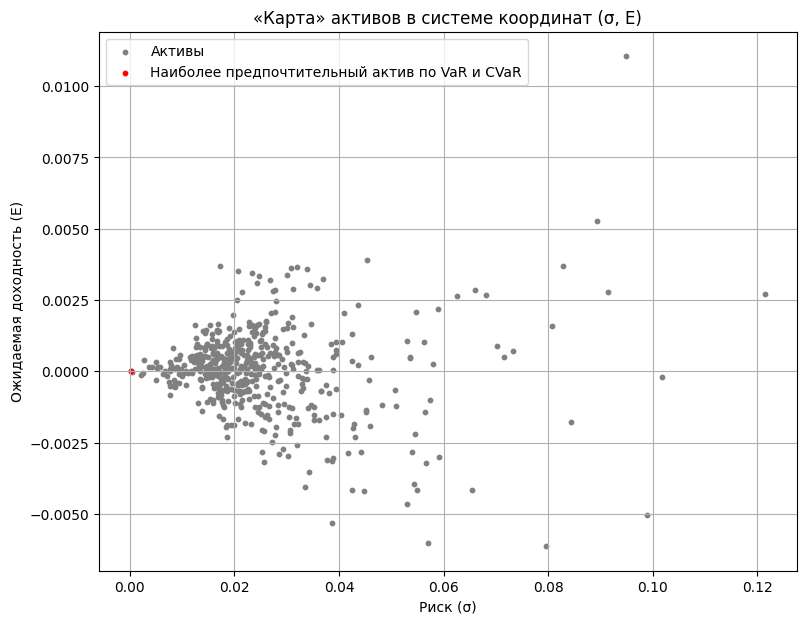

In [138]:
best_active = risk_and_return.loc[risk_and_return['Ticker'] == 'HETA3.SA']
print(best_active)

plt.figure(figsize=(9, 7))
plt.scatter(risk_and_return['σ'], risk_and_return['E'], s=10, color='grey', label='Активы')
plt.scatter(best_active['σ'], best_active['E'], s=10, color='red', label='Наиболее предпочтительный актив по VaR и CVaR')
plt.title('«Карта» активов в системе координат (σ, E)')
plt.xlabel('Риск (σ)')
plt.ylabel('Ожидаемая доходность (E)')
plt.legend()
plt.grid()
plt.show()

Как мы видим, актив имеет практически нулевую ожидаемую доходность. Поэтому насколько полезен этот актив сказать крайне тяжело.

# 4. Нормальность распределений доходностей
### - Выбор нескольких интересных (значимых) активов рынка.
### - В предположении, что наблюдаемые доходности выбранных активов являются повторной выборкой из некоторого распределения исследовать (выборочно) распределения доходностей выбранных активов.
### - Можно ли считать, что распределения доходностей подчиняются нормальному закону распределения?
### - Если ответ отрицательный, какие другие законы распределения доходностей соответствуют данным наблюдений?


Сначала выберем 5 тикеров которые торговали максимум дней (246). Тк как у нас обязательно у каждого актива 2018-01-01 = NaN, то должно получится 245 строчек. Если логарифмическая доходность равна нулю, то это значит, что по сравнению с предыдущим днем цена актива не поменялась. Мы хотим найти активы с минимальных количеством таких дней. И последнее условие - ожидаемая доходность должна быть больше нуля.

In [139]:
selected_tickers = []
for ticker in tickers:
    returns = data[ticker].dropna() # Удаляем NaN, если они есть
    lst = data[ticker].tolist()
    if returns.shape[0] == 245 and lst.count(0) <= 1 and risk_and_return.loc[risk_and_return['Ticker'] == ticker]['E'].values[0] > 0:
        selected_tickers.append(ticker)
    if len(selected_tickers) >= 5:
        break

selected = find_E_n_sigma(data, selected_tickers)
print(selected)

     Ticker         E         σ
0  AMER3.SA  0.003030  0.034552
1  CVCB3.SA  0.000833  0.025087
2  ITUB4.SA  0.000790  0.018876
3  MGLU3.SA  0.003370  0.029962
4  PSSA3.SA  0.001468  0.020805


Мы нашли 5 активов, у которых всего 1 log return = 0. Их мы и будем исследовать. Покажем их на карте.

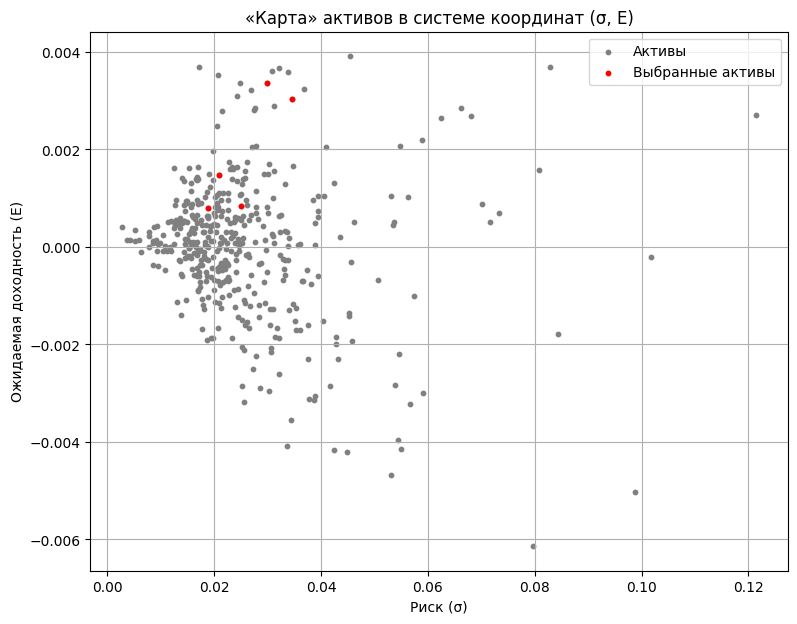

In [104]:
# Построение карты активов в системе координат (σ, E)
plt.figure(figsize=(9, 7))
plt.scatter(risk_and_return['σ'], risk_and_return['E'], s=10, color='grey', label='Активы')
plt.scatter(selected['σ'], selected['E'], s=10, color='red', label='Выбранные активы')
plt.title('«Карта» активов в системе координат (σ, E)')
plt.xlabel('Риск (σ)')
plt.ylabel('Ожидаемая доходность (E)')
plt.legend()
plt.grid()
plt.show()

Для наглядности распределения доходностей изобразим их на гистограме и Q-Q plot. Q-Q plot помогает оценить степень отклонения данных от теоретического распределения. В нашем случае отклонение от нормального распределения. Будем использовать тест Шапиро-Уилка, чтобы понять пожчиняются ли распределения нормальному закону. 

========== AMER3.SA ====================================================================== 

Статистика = 0.9932465745374831, 
p = 0.3335745398032673 

Распределение можно считать нормальным (p > 0.05) 



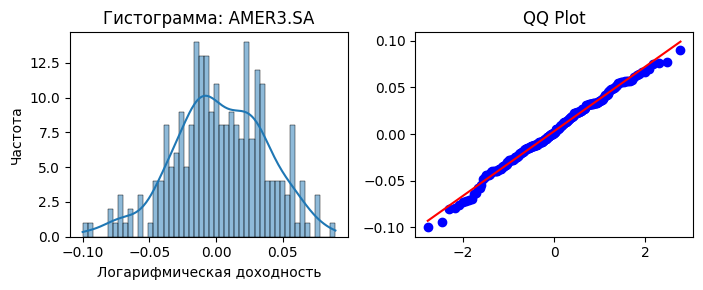

========== CVCB3.SA ====================================================================== 

Статистика = 0.9963975168030549, 
p = 0.848632061755241 

Распределение можно считать нормальным (p > 0.05) 



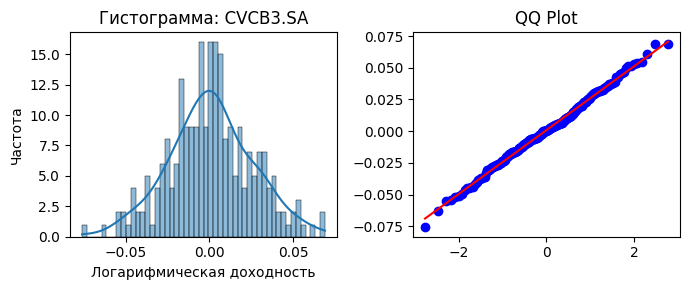

========== ITUB4.SA ====================================================================== 

Статистика = 0.9948154328909589, 
p = 0.5731480522161849 

Распределение можно считать нормальным (p > 0.05) 



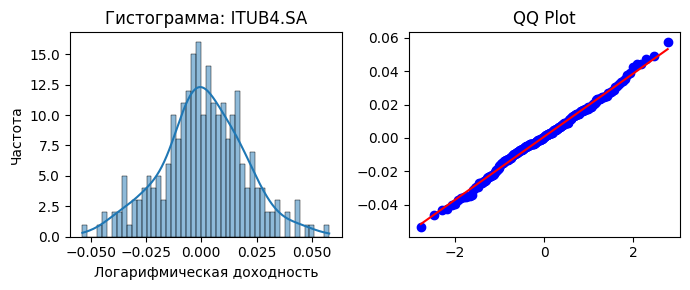

========== MGLU3.SA ====================================================================== 

Статистика = 0.9819742335012964, 
p = 0.0033444789035238336 

Распределение не является нормальным (p <= 0.05) 



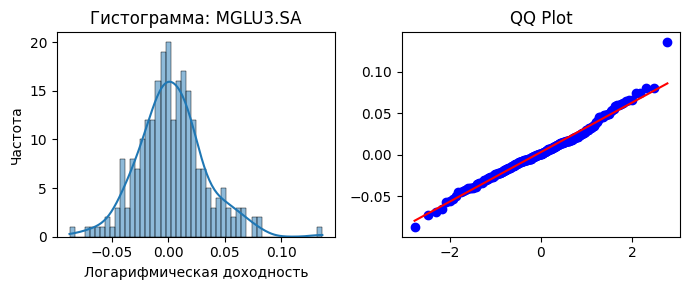

========== PSSA3.SA ====================================================================== 

Статистика = 0.9962545804870233, 
p = 0.8264284753644706 

Распределение можно считать нормальным (p > 0.05) 



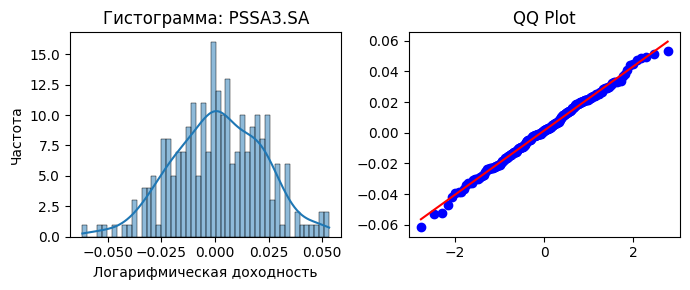

In [105]:
import seaborn as sns
from scipy import stats

for ticker in selected_tickers:
    returns = data[ticker].dropna() # Удаляем NaN, если они есть

    print('='*10, ticker, '='*70, '\n')

    # Тест Шапиро-Уилка
    stat, p_value = stats.shapiro(returns)
    print(f'Статистика = {stat}, \np = {p_value} \n')
    if p_value > 0.05:
        print(f'Распределение можно считать нормальным (p > 0.05) \n')
    else:
        print(f'Распределение не является нормальным (p <= 0.05) \n')

    plt.figure(figsize=(7, 3))
    plt.subplot(1, 2, 1)
    sns.histplot(returns, bins=50, kde=True)
    plt.title(f'Гистограмма: {ticker}')
    plt.xlabel('Логарифмическая доходность')
    plt.ylabel('Частота')

    # QQ plot
    plt.subplot(1, 2, 2)
    stats.probplot(returns, dist="norm", plot=plt)
    plt.title(f'QQ Plot')
    plt.xlabel('')
    plt.ylabel('')

    # Показ графиков
    plt.tight_layout()
    plt.show()

Как бы стрнанно не выглядели некоторые графики, но тест Шапира-Уилка и Q-Q plot показывают, что доходности 4 из 5 выбранных активов подчиняются нормальному закону распределения.

Актив 'MGLU3.SA' среди доходностей имеет один выброс и, не смотря на, можно сказать, самую красивую гистограмму, не подчиняется нормальному закону распределения.